In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#datadir = '/home/mer49/Dropbox (Cambridge University)/Shared/Prannoy/Code/20200317 MER GPs/'
datadir = "/home/cfs/mer49/gp/"

from util            import *
from basics          import *
from simulate_data   import *
from estimators      import *
from config          import *
from scipy.special   import *
from functools       import lru_cache as cache
from opt_einsum      import contract
from scipy.io        import loadmat
from IPython.display import clear_output
configure_pylab()

# This code benefits considerably from using single-precision floating point
# Jax's fft is slow
# Numpy's fft pathologically casts to float64
# Scipy's seems ok
from scipy.fft import *

# Set constants

In [2]:
tol    = 1e-4      # Newton convergence tolerance
mintol = 1e-5      # Minimum residual tolerance
L      = 128       # Grid size ( bins per linear distance )
T      = L*L       # Total number of basis functions (bins per unit area)
res    = 50        # Upsampling/interpolation resolution when estimating period
pad    = 0.6       # Pad to avoid wrap-around from circular convolution; 0.5 = no padding
Fs     = 50.0      # Sample rate of data in Hz ( samples/second )
Œît     = 1/Fs      # seconds / sample
Fl     = 0.25      # Low-frequency cutoff in Hz for smoothing path trajcetory for heading

# Find and load data

In [3]:
# 2D grid coordinates as complex numbers
coords = zgrid(L)
bins   = linspace(0,1,L+1,dtype='float32')

# Resolution for the camera used to record R1 is 350px/m;
# resolution for other rats (R11 and R18) was 338px/m
#px_p_meter = 338
#dataset    = 'R18_20200131_1to2_EC_good.mat'
#px_p_meter = 338
#dataset    = 'R11_20190607_1to2_EC_good.mat'
px_p_meter  = 350
dataset     = 'R1_20190823_2to1_EC_good.mat'
datasetname = dataset.split('_')[0]
dataset_ID  = re.match('(R\d+)_(\d+)',dataset).group(0)

# Load all datasets from this day
data = loadmat(datadir+dataset,squeeze_me=True)
xy50 = data['xy50'] # Position
sp50 = data['sp50'] # Spikes
hd50 = data['hd50'] # Head angle
ndatasets  = len(xy50)

# Which datasets to process? 
do_datasets = [1]#range(ndatasets)

# Rescale location data from all datasets using same transformation
allxy50 = np0.concatenate(xy50)
x,y     = allxy50.T
minx,maxx,miny,maxy = np.min(x),np.max(x),np.min(y),np.max(y)
delta   = np0.max([maxx-minx,maxy-miny])
scale   = (1-1e-6)/(delta*pad*2)

# Record grid scale
bins_p_meter = scale*L*px_p_meter
cm_p_bin     = 100/bins_p_meter
print('cm  per spatial bin',cm_p_bin)
print('cm¬≤ per spatial bin',cm_p_bin**2)

cm  per spatial bin 3.1682123531314383
cm¬≤ per spatial bin 10.037569514534646


In [4]:
# Load a given dataset, rescaling the spatial locations
def load_dataset(fn,dataindex):
    # Get dataset
    data = loadmat(fn,squeeze_me=True)
    xy50 = data['xy50'] # Position
    sp50 = data['sp50'] # Spikes
    hd50 = data['hd50'] # Head angle
    # Get specified dataset
    x,y  = xy50[dataindex].T
    s    = sp50[dataindex]
    x    = (x-(maxx+minx)/2+delta*pad)*scale
    y    = (y-(maxy+miny)/2+delta*pad)*scale
    return s,x,y,scale

def bin_spikes(x,y,s,bins,w=None):
    # Bin spike counts
    N    = histogram2d(y,x,(bins,bins),density=0,weights=w)[0]
    ws   = s if w is None else array(s)*array(w)
    K    = histogram2d(y,x,(bins,bins),density=0,weights=ws)[0]
    return N,K

In [5]:
Œît

0.02

In [6]:
# Get specific dataset
idata = do_datasets[0]
s,x,y,scale = load_dataset(datadir+dataset,idata)

# Grab spikes
st    = find(s>0)              # samples with a spike
xs,ys = x[st],y[st]            # locations where spikes happened
sk    = s[st]                  # number of spikes per spike event
Nv,K  = bin_spikes(x,y,s,bins) # count number of visits and number of spikes per bin
mask  = blur(Nv>0,2)>0.1       # mask out areas with no data

# Establish real, physical units for these quantities

# Nv:    sample / bin
# K:     spikes / bin
# Œît:    seconds / t-bin
# Nt:    (samples/bin) √ó (seconds/sample) ‚Üí seconds/bin
# Œîx:    cm¬≤ / bin
# yb:    (spikes /bin) √∑ (seconds/bin)  ‚Üí spikes/second
# dwell: (seconds/bin) √∑ (cm¬≤    /bin)  ‚Üí seconds/cm¬≤
# œÅ:     (spikes /bin) √∑ (cm¬≤    /bin)  ‚Üí spikes/cm¬≤

#*Œîts
Nt    = Nv             # seconds/bin
Œîx    = cm_p_bin**2      # cm¬≤ / bin
yb    = nan_to_num(K/Nt) # spikes/second
dwell = Nt*Œîx            # seconds/cm¬≤
œÅ     = K/Œîx             # spikes/cm¬≤

# This form of the log-Poisson likelihood is invariant to spatiotemporal discretization 
# sum over bins { (seconds/bin) (spikes/second) - (spikes/bin) }
# ‚Üí # of spikes (constant per dataset)
# sum_over_bins( Nt*Œª - K * Œºx )
# sum_over_bins( Nt*Œª - Nt * yb * Œºx )

# for some reason we also need to divide by time bins for things to work out? 
# what gives? 

# Or, to keep spatial units, use this
# (seconds/cm¬≤)(spikes/second) ‚Üí spikes/cm¬≤; sum over bins (sp/cm¬≤) ‚Üí bin*(sp/cm¬≤)
# {bin*(sp/cm¬≤)} √ó (cm¬≤ / bin) ‚Üí # spikes (constant per dataset)
# sum_over_bins(dwell * Œª - œÅ) * Œîx

# Confirm that these match a sum over time
# sum_over_time( spikes/sample * samples/second )

We need to be very careful about units. The choice of grid size should not affect the likelihood. Use physical units for Œª:

$$
\lambda = e^{z + \mu_0} \text{ in units of spikes per second}
$$

$$
\Pr(z | y ) = \frac {\Pr(z)} {\Pr(y)} \Pr(y|z)
$$

$$
\Pr(z | y ) = \frac {\Pr(z)} {\Pr(y)} \prod_t \frac 1 {y_t!} \lambda_t^{y_t} e^{-\lambda_t}
$$

$$
\Pr(z | y ) = \frac {1} {\Pr(y)} 
|2\pi\Sigma|^{-\frac 1 2} e^{-\frac12 z^\top\Sigma^{-1} z}
\prod_t \frac 1 {y_t!} \lambda_t^{y_t} e^{-\lambda_t}
$$

$$
\ln\Pr(z|y) = \text{constant} 
-\frac 12 \ln|2\pi\Sigma| -\frac12 z^\top\Sigma^{-1} z
+
\sum_t y_t \ln(\lambda_t) - \lambda_t
$$

To keep things unitless (invariant to choice of Œît, Œîx) we need... 


$$
\ln\Pr(z|y) = \text{constant} 
-\frac 12 \ln|2\pi\Sigma| - \Delta x^2 \frac12 z^\top\Sigma^{-1} z
+
\sum_t y_t \ln(\lambda_t) - \lambda_t
$$


$$
\ln\Pr(z|y) = \text{constant} 
-\frac 12 \ln|2\pi\Sigma| - \frac 1{L^4} \frac12 z^\top\Sigma^{-1} z
+
\sum_t y_t \ln(\lambda_t) - \lambda_t
$$

I do not know

Period is 28.323818 cm (8.940000 bins)


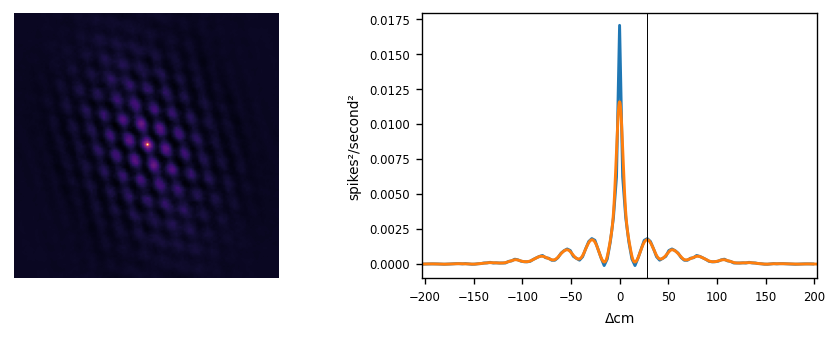

In [7]:
# Nv:    sample / bin
# K:     spikes / bin
# Œît:    seconds / t-bin
# Nt:    (samples/bin) √ó (seconds/sample) ‚Üí seconds/bin
# Œîx:    cm¬≤ / bin
# yb:    (spikes /bin) √∑ (seconds/bin)  ‚Üí spikes/second
yb    = nan_to_num(K/Nt) # spikes/second

# (spikes/bin) √∑ (sample/bin) ‚Üí spikes/sample
#Œªhat   = nan_to_num(K/Nv)

# Calibrate grid scale
Œªhat   = yb # spikes/second
acorr2 = fft_acorr(Œªhat,mask) # Get 2D autocorrelation
acorrR = radial_average(acorr2) # Get radial autocorrelation
res    = 50                     # Subsampling resolution
P,acup = acorr_peak(acorrR,res) # Distance to first peak in bins

subplot(121)
imshow(acorr2)
axis('off')

print('Period is %f cm (%f bins)'%(P*cm_p_bin,P))

subplot(122)
plot((arange(L)-L/2)*cm_p_bin,acorrR)
plot((linspace(-L/2,L/2,L*res))*cm_p_bin,acup)
xlim(-L/2*cm_p_bin,L/2*cm_p_bin)
xlabel('Œîcm')
ylabel('spikes¬≤/second¬≤')
axvline(P*cm_p_bin,color='k',lw=0.5)

Text(0.5, 0.98, 'R1_20190823_2to1_EC_good.mat dataset 1')

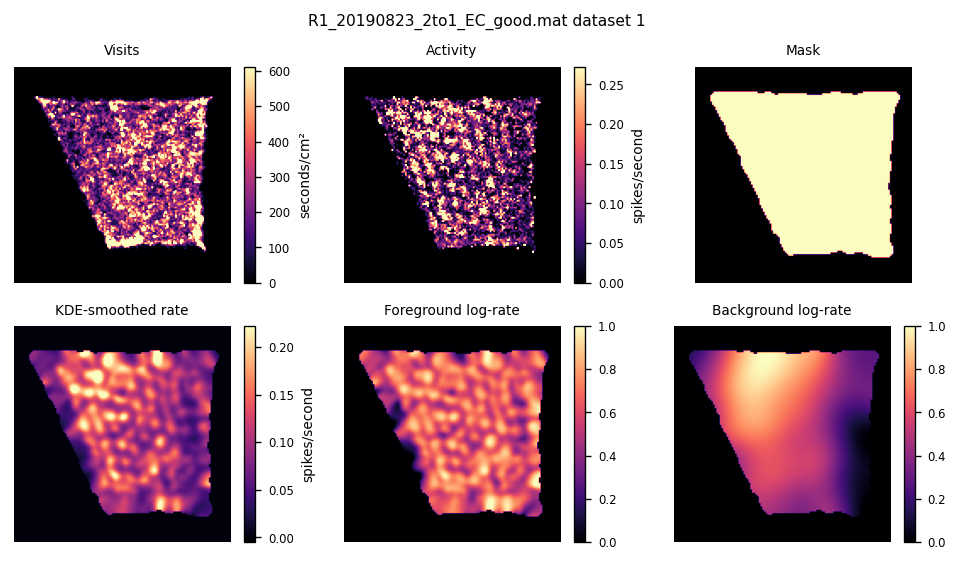

In [8]:
# Precompute variables; Passed as globals to jac/hess
fgœÉ  = P/pi           # In units of linear-bins
bgœÉ  = fgœÉ*5          # In units of linear-bins
n    = Nt.ravel()     # seconds/bin
y    = yb.ravel()     # spikes/second within each bin
Œªhat = kdeŒª(Nt,K,fgœÉ) # KDE estimated rate
Œªbg  = kdeŒª(Nt,K,bgœÉ) # Background rate
lŒªh  = slog(Œªhat)     # Log rate
lŒªb  = slog(Œªbg)      # Log background
lŒªf  = lŒªh - lŒªb      # Foreground log rate

# Initial guess for kernel height
œÉ0   = zerolag(radial_acorr(lŒªf,mask))

figure(figsize=(7,4))
subplot(231)
title('Visits');
axis('off')
imshow(Nt*Œîx,vmin=percentile(Nt*Œîx,5),vmax=percentile(Nt*Œîx,95));
colorbar(label='seconds/cm¬≤')
subplot(232)
title('Activity');
axis('off')
imshow(yb,vmin=percentile(yb,1),vmax=percentile(yb,95));
colorbar(label='spikes/second')
subplot(233)
showim(mask,'Mask');
subplots_adjust(top=0.8)
suptitle('%s dataset %d'%(dataset,idata))
subplot(234)
title('KDE-smoothed rate');
axis('off')
imshow(Œªhat*mask,vmin=percentile(Œªhat,1),vmax=percentile(Œªhat,99));
colorbar(label='spikes/second')
subplot(235)
showim(lŒªf,'Foreground log-rate',mask=mask);
colorbar()
subplot(236)
showim(lŒªb,'Background log-rate',mask=mask);
colorbar()
tight_layout()
suptitle('%s dataset %d'%(dataset,idata))

# Define hyperparameter search grid

- Œ≤ is the kernel height
- P is the kernel period

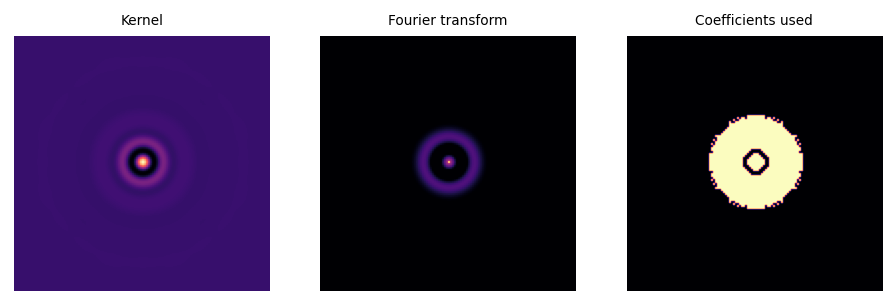

In [9]:
rP   = sqrt(2)
rŒ≤   = 2
P_lo = P/rP
P_hi = P*rP
Œ≤_lo = 1/rŒ≤
Œ≤_hi = 1*rŒ≤
NP   = 21
NŒ≤   = 21
Ps   = float32(exp(linspace(log(P_lo),log(P_hi),NP)))
Œ≤s   = float32(exp(linspace(log(Œ≤_lo),log(Œ≤_hi),NŒ≤))[::-1])

@cache(NP*2)
def make_kernel_ft(L,P,œÉ0,dc=1e1,k=3):
    coords   = zgrid(L)
    window   = hanning(L)
    window   = fftshift(outer(window,window))
    kern     = j0(fftshift(abs(coords*2*pi/P)))*window
    clip     = fftshift(abs(coords)<P*jn_zeros(0,k)[-1]/(2*pi))
    kern     = kern*clip
    kern     = blur(kern,P/pi)
    kern     = repair_small_eigenvalues(kern*œÉ0/np.max(kern),1e-5)
    Kf       = np0.array(real(fft2(kern)))
    Kf[0,0] += dc
    return Kf

use2d = zeros((L,L),dtype='bool')
for p in Ps:
    Kf  = make_kernel_ft(L,p,œÉ0)
    thr = np.max(array(sorted(abs(Kf).ravel()))[:-1])
    thr = percentile(abs(Kf).ravel(),95)
    use2d |= (abs(Kf))>thr

# Define low-rank Fourier space projection 
use2d   = use2d | use2d.T    # Ensure symmetric
use     = find(use2d.ravel()) # Indecies into LxL array to use4
R        = len(use)            # Number of components used
down     = eye(T)[use]         # Matrix to trim down a Fourier transform 

# Define low-rank cuts for 1D transform
use1d  = any(use2d,axis=0)                 # Indecies to use along L
f1De   = fft(eye(L),norm='ortho')[use1d,:] # 1D Fourier components used
f1De   = complex64(f1De)
R1d    = sum(use1d)                        # Number of components used in the 1D tranform
usecut = find(use2d[:,use1d][use1d,:])     # Subset of reduced 1Dx1D transform kept in full 2D transform

def reverse(A):
    # Exchange positive and negative frequencies in a 2D fourier transform
    return roll(roll(A[::-1,:],1,axis=0)[:,::-1],1,axis=1)

# Positive/negative frequency flip in reduced representation
hperm = int32(down@reverse((down.T@(arange(R))).reshape(L,L)).ravel())

def er(a,b): print(max(abs(a-b)))
def hcv(kh,xh):
    kh = kh/2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)*xh+(kh-kr)*xr
def hcm(kh,xh):
    kh = kh/2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)[:,None]*xh+(kh-kr)[:,None]*xr
def Ftv(v):  # Collapse vector DOWN
    return fhtv(v)[use]
def Fv(v):
    #return fhtv(zeros(T).at[use].set(v))
    x = zeros(T)
    x[use] = v
    return x
def fhtv(v):
    v = fft2(v.reshape(L,L),norm='ortho').ravel()
    return v.real+v.imag
def fhtA(x):
    x = fft2(x.reshape(x.shape[0],L,L),norm='ortho').reshape(x.shape[0],T)
    return x.real+x.imag
def FtA(A):  # Collapse matrix DOWN
    return fhtA(A.T).T[use,:]
def FA(A): 
    # Syntax for jax
    # return fhtA(zeros((T,A.shape[-1])).at[use,:].set(A).T).T
    X = zeros((T,A.shape[-1]))
    X[use,:] = A
    return fhtA(X.T).T
def dv(Q):
    return sum(FA(tril(Q))**2,1)
def chol(x):
    return numpy.linalg.cholesky(x)
def ltinv(ch):
    q,info = scipy.linalg.lapack.dtrtri(ch,lower=True)
    if info!=0: raise ValueError('lapack.dtrtri: '+(
            'argument %d invalid'%-info if info<0 
            else 'diagonal element %d is 0'%info))
    return q
def cv(K,v):
    return real(ifft2(fft2(v.reshape(L,L),norm='ortho')*K,norm='ortho')).ravel()
def cm(K,M):
    return real(ifft2(
        K[:,:,None]*fft2(M.reshape(L,L,M.shape[-1]),axes=(0,1)),
        axes=(0,1))).reshape(T,M.shape[-1])
def logdet(A):
    return sum(slog(diag(chol(A))))*2
    
# Precompute all manner of useful forms of a kernel
# TODO: check whether all of these are used
@cache(NP*2)
def prepare_kernel(p):
    Kf = make_kernel_ft(L,p,œÉ0)
    Œõf = 1.0/Kf
    K0 = real(ifft2(Kf))
    Kh = (Kf.real+Kf.imag).ravel()[use]
    Œõh = (Œõf.real+Œõf.imag).ravel()[use]
    sK = sum(log(Kf[use2d]))
    nK = sum(use2d)
    Œõr = hcm(Œõh,eye(R))
    K0,Kf,Œõf,Kh,Œõh,sK,nK,Œõr = map(float32,[K0,Kf,Œõf,Kh,Œõh,sK,nK,Œõr])
    return K0,Kf,Œõf,Kh,Œõh,sK,nK,Œõr

K0,Kf,Œõf,Kh,Œõh,sK,nK,Œõr = prepare_kernel(P)
subplot(131)
showkn(K0,'Kernel')
subplot(132)
showkn(Kf,'Fourier transform')
subplot(133)
showkn(use2d,'Coefficients used')

# Double check Hartley transform

- Kernels are Hermitian; Hartley transform is the Fourier transform

/home/cfs/mer49/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


6.71327390566745e-07


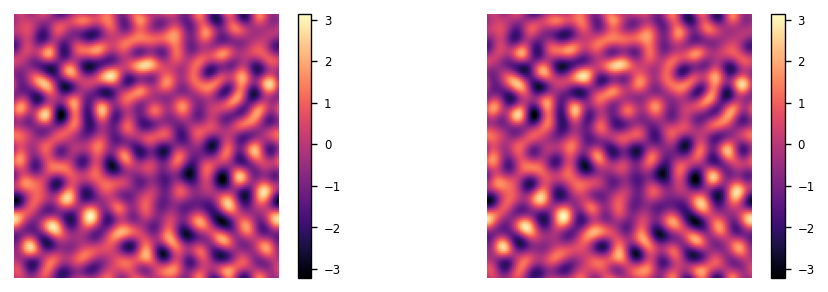

In [10]:
K0,Kf,Œõf,Kh,Œõh,sK,nK,Œõr = prepare_kernel(p)

x  = randn(L,L)
xf = fft2(x,norm='ortho')[use2d].ravel()
xh = xf.real + xf.imag
ch = xh*Kh
c  = zeros((L,L))
c[use2d] = ch
c  = fft2(c,norm='ortho')
c  = c.real + c.imag

subplot(121)
imshow(c.reshape(L,L))
axis('off')
colorbar()
subplot(122)

#c2 = ifft2(Kf*fft2(x)).real

xf = fft2(x)[use2d]
ch = xf*fft2(K0)[use2d]
c2 = zeros((L,L))
c2[use2d] = ch
c2 = ifft2(c2).real

f1 = fft2(x)[use2d]
f2 = fft2(K0)[use2d].real
f3 = f1*f2
c2 = zeros((L,L),dtype='complex64')
c2[use2d] = f3
c2 = ifft2(c2).real

imshow(c2)
axis('off')
colorbar()

print(np.max(abs(c-c2)))

# Check Choleskey inverse

In [11]:
def chinv(X):
    '''
    Q  = float64(randn(100,100))
    Q  = Q@Q.T
    i1 = inv(Q)
    i2 = chinv(Q)
    i2 = i2.T@i2
    np.max(abs(i1-i2))
    '''
    X = float64(X)
    X = scipy.linalg.cholesky(X,lower=True)
    X,info = scipy.linalg.lapack.dtrtri(X,lower=True)
    if info!=0: raise ValueError('lapack.dtrtri: '+(
            'argument %d invalid'%-info if info<0 
            else 'diagonal element %d is 0'%info))
    return X

Q  = float64(randn(100,100))
Q  = Q@Q.T
i1 = inv(Q)
i2 = chinv(Q)
i2 = i2.T@i2
np.max(abs(i1-i2))

3.936406756110955e-12

# We operate in a low-rank subspace

True


(-0.5, 127.5, -0.5, 127.5)

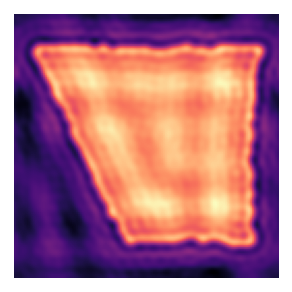

In [12]:
def down(u):
    u = fft2(u.reshape(L,L),norm='ortho')[use2d]
    return u.real + u.imag
def up(u):
    x = zeros((L,L))
    x[use2d] = u
    x = fft2(x,norm='ortho').ravel()
    return x.real + x.imag
x = randn(T)
x = up(down(x))
print(allclose(up(down(x)),x))
imshow(up(down(mask)).reshape(L,L))
axis('off')

# Check that low-rank inverse is correct 

We can't actually compute this easily.

In [13]:
# Streamline precomputation of low-rank collapse of diagonal matrix
f1e = fft(eye(L),norm='ortho')[use1d,:]
f2e = f1e[:,None,:,None]*f1e[None,:,None,:]
h2e = f2e.real + f2e.imag
h2e = h2e.reshape(R1d*R1d,L*L)[usecut]
# print('Looks semi-orthoginal:',allclose(eye(R), h2e@h2e.T))

Œ≤   = 1.0
Œº   = lŒªf.ravel()
Œº0  = lŒªb.ravel()
v   = 0.*Œº+randn(T)*1e-6
Œª   = exp(Œº + Œº0 + v/2)
nŒª  = n*Œª
x   = sqrt(nŒª)
x   = x[None,:]*h2e
xxt = x@x.T

'''
Check that this agrees with other ways of comput Fùîª[nŒª]F'
(it does)
other = FtA(FtA(diag(nŒª)).T).T
print(np.max(abs(other-xxt)))
q = FtA(diag(sqrt(nŒª)))
qqt = q@q.T
print(np.max(abs(qqt-xxt)))
'''

'''
Sanity check the prior kernel
print(np.max(abs(hcm(Œõh,eye(R))-diag(Œõh))))
'''

Œõp  = Œ≤*diag(Œõh) + xxt
Cp  = chinv(Œõp)
Œ£p  = Cp.T @ Cp

'''
Sanity check Choleskey inverse
print(allclose(eye(R),Œ£p@Œõp))
'''

def fast_low_rank_covariance(nŒª,Œ≤,p):
    K0,Kf,Œõf,Kh,Œõh,sK,nK,Œõr = prepare_kernel(p)
    x   = sqrt(nŒª)
    x   = x[None,:]*h2e
    xxt = x@x.T
    Œõp  = Œ≤*diag(Œõh) + xxt
    Cp  = chinv(Œõp)
    Œ£p  = Cp.T @ Cp
    return Œ£p
    
def fast_covariance_diagonal(nŒª,Œ≤,p):
    K0,Kf,Œõf,Kh,Œõh,sK,nK,Œõr = prepare_kernel(p)
    x   = sqrt(nŒª)
    x   = x[None,:]*h2e
    xxt = x@x.T
    Œõp  = Œ≤*diag(Œõh) + xxt
    A   = chinv(Œõp)
    # Need to unpack this on the left
    X  = zeros((R,T))
    X[:,use] = A
    A  = X.reshape(R,L,L)
    DF = fft2(A,norm='ortho')
    DF = DF.real + DF.imag
    DF = DF.reshape(R,T)
    return sum(DF**2,0)

def fast_covariance_diagonal(nŒª,Œ≤,p):
    K0,Kf,Œõf,Kh,Œõh,sK,nK,Œõr = prepare_kernel(p)
    x   = sqrt(nŒª)
    x   = x[None,:]*h2e
    xxt = x@x.T
    Œõp  = Œ≤*diag(Œõh) + xxt
    A   = chinv(Œõp)
    '''
    # Need to unpack this on the left
    X  = zeros((R,T))
    X[:,use] = A
    A  = X.reshape(R,L,L)
    DF = fft2(A,norm='ortho')
    DF = DF.real + DF.imag
    DF = DF.reshape(R,T)
    '''
    X  = zeros((L,L,R))
    X[use2d] = A.T
    DF = fft2(X,axes=(0,1),norm='ortho')
    DF = DF.real + DF.imag
    DF = DF.reshape(T,R).T
    
    return sum(DF**2,0)

# Double check that loss is correct 

In [14]:
fudge = sum(n)
fudge

240023.0

In [15]:
numpy.set_printoptions(precision=5)

def logdet(A):
    return sum(log(diag(scipy.linalg.cholesky(A,lower=True))))*2

def loss(Œº,v,Œ≤,p):
    '''
    n'(Œª-y‚àòŒº)  ¬ΩŒº'Œõ‚ÇÄŒº ¬Ωln|Œ£‚ÇÄ| -¬Ωln|Œ£| ¬Ωtr[Œõ‚ÇÄŒ£]
    '''
    K0,Kf,Œõf,Kh,Œõh,sK,nK,Œõr = prepare_kernel(p)
    Œª   = exp(Œº + Œº0 + v/2)
    nŒª  = n*Œª
    Œ£r  = fast_low_rank_covariance(nŒª,Œ≤,p)
    Œ≤ŒõŒ£ = Œ≤*Œõr@Œ£r
    l1  = n@(Œª-y*Œº) # bins( s/bin*spike/s - spike/bin ) ‚Üí spikes
    l2  = Œ≤*(Œº@cv(Œõf,Œº)/2)
    l3  = -logdet(Œ≤*Œõr)/2
    l4  = -logdet(Œ£r)/2
    l5  = trace(Œ≤ŒõŒ£)/2
    return array([l1/fudge,l2/T,l3/T,l4/T,l5/T])

tic()
l1 = loss(Œº,v,Œ≤,p)
tic('1')
print(l1)
print(sum(l1))

def loss_lowrank(Œº,v,Œ≤,p):
    '''
    n'(Œª-y‚àòŒº)  ¬ΩŒº'Œõ‚ÇÄŒº ¬Ωln|Œ£‚ÇÄ| -¬Ωln|Œ£| ¬Ωtr[Œõ‚ÇÄŒ£]
    '''
    K0,Kf,Œõf,Kh,Œõh,sK,nK,Œõr = prepare_kernel(p)
    
    # Send Œº to low-rank space
    Œº   = ifft2(fft2(Œº.reshape(L,L))*use2d).ravel().real
    
    Œª   = exp(Œº + Œº0 + v/2)
    nŒª  = n*Œª
    Œ£r  = fast_low_rank_covariance(nŒª,Œ≤,p)
    Œ≤ŒõŒ£ = Œ≤*Œõr@Œ£r
    
    l1  = n@(Œª-y*Œº) # bins( s/bin*spike/s - spike/bin ) ‚Üí spikes
    l2  = Œ≤*(Œº@cv(Œõf,Œº)/2)
    l3  = -logdet(Œ≤*Œõr)/2
    l4  = -logdet(Œ£r)/2
    l5  = trace(Œ≤ŒõŒ£)/2
    return array([l1/fudge,l2/T,l3/T,l4/T,l5/T])

tic()
l2 = loss_lowrank(Œº,v,Œ≤,p)
tic('2')
print(l2)
print(sum(l2))
print(abs(l1 - l2))

def loss_optimized(Œº,v,Œ≤,p):
    '''
    n'(Œª-y‚àòŒº)  ¬ΩŒº'Œõ‚ÇÄŒº ¬Ωln|Œ£‚ÇÄ| -¬Ωln|Œ£| ¬Ωtr[Œõ‚ÇÄŒ£]
    '''
    K0,Kf,Œõf,Kh,Œõh,sK,nK,Œõr = prepare_kernel(p)
    Œº   = ifft2(fft2(Œº.reshape(L,L))*use2d).ravel().real
    Œª   = exp(Œº + Œº0 + v/2)
    nŒª  = n*Œª
    x   = sqrt(nŒª)[None,:]*h2e
    C   = chinv(Œ≤*diag(Œõh) + x@x.T)
    l1  = n@(Œª-y*Œº) # bins( s/bin*spike/s - spike/bin ) ‚Üí spikes
    l2  = Œ≤*(Œº@cv(Œõf,Œº)/2) # 
    l3  = sK/2-nK*log(Œ≤)/2
    l4  = -sum(log(diag(C)))
    l5  = Œ≤*sum(C**2 * Œõh.ravel())/2
    return array([l1/fudge,l2/T,l3/T,l4/T,l5/T])

# Why optimized look like reference, not low-rank?

tic()
l3 = loss_optimized(Œº,v,Œ≤,p)
tic('2')
print(l3)
print(sum(l3))

print(abs(l3-l1))
print(abs(l3-l2))

compare = array([l1,l2,l3])
compare.T

Œît = 1136 ms  elapsed for 1
[ 1.00193e-01  5.87950e+04 -2.18921e-01  2.37613e-01  4.19677e-02]
58795.132923170575
Œît = 1180 ms  elapsed for 2
[ 5.60312e-01  3.95669e+04 -2.18921e-01  2.42553e-01  4.15755e-02]
39567.47838956619
[4.60119e-01 1.92281e+04 0.00000e+00 4.93961e-03 3.92185e-04]
Œît = 815 ms   elapsed for 2
[ 5.60312e-01  3.95669e+04 -2.18921e-01  2.42553e-01  4.15755e-02]
39567.47838956619
[4.60119e-01 1.92281e+04 0.00000e+00 4.93961e-03 3.92185e-04]
[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.38778e-17]


array([[ 1.00193e-01,  5.60312e-01,  5.60312e-01],
       [ 5.87950e+04,  3.95669e+04,  3.95669e+04],
       [-2.18921e-01, -2.18921e-01, -2.18921e-01],
       [ 2.37613e-01,  2.42553e-01,  2.42553e-01],
       [ 4.19677e-02,  4.15755e-02,  4.15755e-02]])

In [16]:
compare = array([l1,l2,l3])
compare.T

array([[ 1.00193e-01,  5.60312e-01,  5.60312e-01],
       [ 5.87950e+04,  3.95669e+04,  3.95669e+04],
       [-2.18921e-01, -2.18921e-01, -2.18921e-01],
       [ 2.37613e-01,  2.42553e-01,  2.42553e-01],
       [ 4.19677e-02,  4.15755e-02,  4.15755e-02]])

# Check simplified Hartley space convolution 

1.5543122344752192e-15


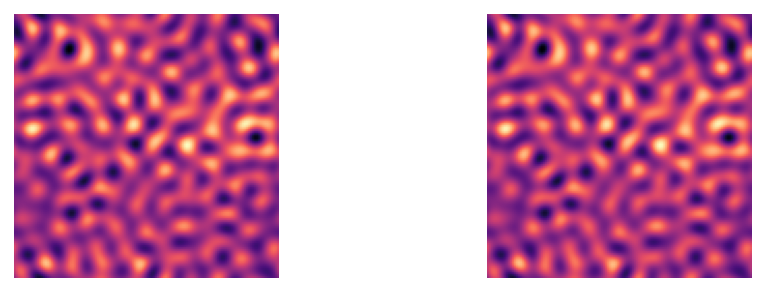

In [17]:
x = randn(L,L)
K0,Kf,Œõf,Kh,Œõh,sK,nK,Œõr = prepare_kernel(p)

x1 = ifft2(Kf*use2d*fft2(x)).real
subplot(121)
imshow(x1)
axis('off')

# With Hartley
a  = fft2(x,norm='ortho')[use2d]
a  = a.imag + a.real
a  = a*Kh
b  = zeros((L,L))
b[use2d] = a
x2 = fft2(b,norm='ortho')
x2 = x2.real + x2.imag
subplot(122)
imshow(x2)
axis('off')

print(np.max(abs(x1-x2)))

# Redo inference 

In [18]:


def infer(Œº,v,Œ≤,p,maxiter=100,showprogress=True):
    Œ≤ = float(Œ≤)
    p = float(p)
    report = print if showprogress else lambda *x:()
    
    report('(initializing)')
    
    # Prepare kernel
    K0,Kf,Œõf,Kh,Œõh,sK,nK,Œõr = prepare_kernel(p)
    KŒ≤ = Kh/Œ≤
    ŒõŒ≤ = Œõh*Œ≤

    # Preconditioner, in low-rank space
    M = op(R,lambda u:KŒ≤*u)
    
    # Send everything down into the low-rank space
    Œºh   = down(Œº)
    vh   = down(v)
    Œº0h  = down(Œº0)
    
    report('(getting variance)')
    
    # Calculate rate with variance correction
    nŒª   = n*exp(Œº + Œº0 + v/2)
    v    = fast_covariance_diagonal(nŒª,Œ≤,p)
    
    report('(optimizing)')
    
    # Interleave mean and variance iterations
    for i in range(maxiter):
        
        # Inner loop optimizes the mean
        for j in range(maxiter):

            # Gradient, in low-rank space
            Œº    = up(Œºh)
            Œª    = exp(Œº + Œº0 + v/2)
            J    = ŒõŒ≤*Œºh + down(n*(Œª-y))

            # Hessian, in low-rank space
            nŒª   = n*Œª
            def Hu(u):
                return ŒõŒ≤*u + down(nŒª*up(u))

            ŒîŒº = minres(op(R,Hu),J,tol=mintol,M=M)[0]
            Œºh -= ŒîŒº
            if max(abs(ŒîŒº))<tol: break
            report('Œº',max(abs(ŒîŒº)),'iteration',i,j)
            
        # Update the variance estimate
        report('(getting variance)')
        
        # Calculate rate with variance correction
        Œº   = up(Œºh)
        nŒª  = n*exp(Œº + Œº0 + v/2)
        v2  = fast_covariance_diagonal(nŒª,Œ≤,p)
        Œîv  = v2-v
        v   = v2
        
        report('Iteration',i)
        report('Œîv',max(abs(Œîv)))
        report('ŒîŒº',max(abs(ŒîŒº)))
        if max(abs(ŒîŒº))<tol and max(abs(Œîv))<tol: break
    
    l1,l2,l3 = loss(Œº,v,Œ≤,p),loss_lowrank(Œº,v,Œ≤,p),loss_optimized(Œº,v,Œ≤,p)
    report('l1:',l1,';',sum(l1))
    report('l2:',l2,';',sum(l2))
    report('l3:',l3,';',sum(l3))
    return Œº,v,concatenate([l1,l2,l3])

In [19]:
#%load_ext snakeviz
#%snakeviz 
v = Œº*0
Œ≤ = 1
tic()
Œº,v,l = infer(Œº,v,Œ≤,P)
tic('took')

(initializing)
(getting variance)
(optimizing)
Œº 1336.8916429869844 iteration 0 0
Œº 9.267221383564655 iteration 0 1
Œº 11.869279721709372 iteration 0 2
Œº 13.615917057731508 iteration 0 3
Œº 15.8577821776032 iteration 0 4
Œº 18.979887647474577 iteration 0 5
Œº 23.433431904061315 iteration 0 6
Œº 28.872986795178107 iteration 0 7
Œº 34.52403782917883 iteration 0 8
Œº 38.15943426828395 iteration 0 9
Œº 35.08668559420358 iteration 0 10
Œº 18.963870412474144 iteration 0 11
Œº 15.747860946938605 iteration 0 12
Œº 12.947497695656537 iteration 0 13
Œº 10.830227077892577 iteration 0 14
Œº 5.15476117688097 iteration 0 15
Œº 5.603253634535384 iteration 0 16
Œº 3.484942068097879 iteration 0 17
Œº 1.5742192154019765 iteration 0 18
Œº 0.5130217583110774 iteration 0 19
Œº 0.22352781046783785 iteration 0 20
Œº 0.0557193688428226 iteration 0 21
Œº 0.003560100033467772 iteration 0 22
(getting variance)
Iteration 0
Œîv 0.016824274035979518
ŒîŒº 1.376776374155149e-05
Œº 0.025194808676355134 iteration 1 

14120.562255859375

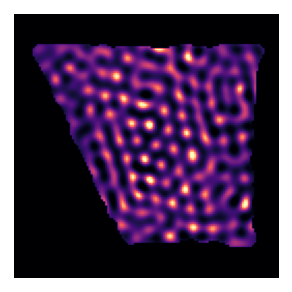

In [20]:
showim(exp((Œº+v/2).reshape(L,L)),mask=mask)

# Sweep Œ≤ and optimize 

In [21]:
# For jupyter notebooks: trigger browser to notify when done
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js('''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''.format(text=text)))
    # Clear the JS so that the notebook doesn't speak again when reopened/refreshed
    #clear_output(False)
def notify(what='attention'):
    #os.system("echo -n '\a'")
    speak(what+'!')

In [22]:
results = []
for i,Œ≤ in enumerate(Œ≤s):
    Œº,v,l = infer(Œº,v,Œ≤,P)
    results += [(Œº,v,l)]
notify('DONE')

(initializing)
(getting variance)
(optimizing)
Œº 3.7845506684918324 iteration 0 0
Œº 0.17057560782765 iteration 0 1
Œº 0.00020284829373220007 iteration 0 2
(getting variance)
Iteration 0
Œîv 0.0018248225847648201
ŒîŒº 9.665784297737278e-09
Œº 0.007203384787625626 iteration 1 0
(getting variance)
Iteration 1
Œîv 5.796061783906736e-06
ŒîŒº 7.161655418029638e-07
l1: [ 0.09789  0.03312 -0.19829  0.21791  0.03947] ; 0.19010326954200335
l2: [ 0.09789  0.03312 -0.19829  0.21791  0.03947] ; 0.1901032695420034
l3: [ 0.09789  0.03312 -0.19829  0.21791  0.03947] ; 0.19010325806675463
(initializing)
(getting variance)
(optimizing)
Œº 0.34693238312931396 iteration 0 0
Œº 0.0019396275724379549 iteration 0 1
(getting variance)
Iteration 0
Œîv 0.0001864147337035521
ŒîŒº 1.8038700611851688e-07
Œº 0.0008037687403169808 iteration 1 0
(getting variance)
Iteration 1
Œîv 6.103066816226521e-07
ŒîŒº 1.1733749489256694e-07
l1: [ 0.0978   0.03228 -0.19488  0.21517  0.0393 ] ; 0.18967942932019993
l2: [ 0.0978  

<IPython.core.display.Javascript object>

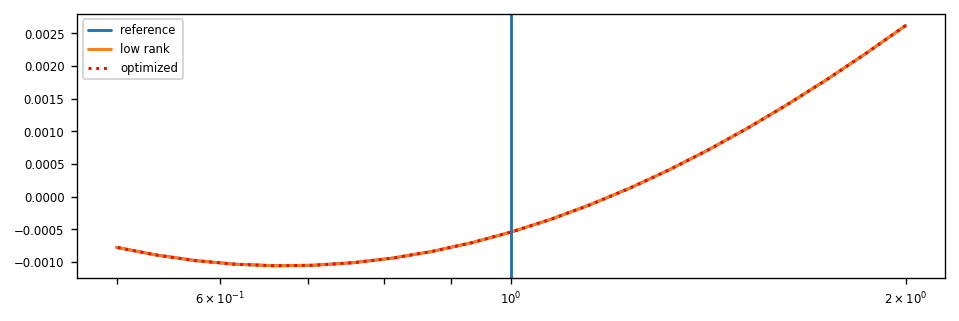

In [23]:
l = array([r[2] for r in results])
l1 = sum(l[:,:5],1)
l2 = sum(l[:,5:10],1)
l3 = sum(l[:,10:],1)
plot(Œ≤s,l1 - mean(l1),label='reference')
plot(Œ≤s,l2 - mean(l2),label='low rank')
plot(Œ≤s,l3 - mean(l3),label='optimized',linestyle=':',color='r')
semilogx()
axvline(1)
legend()

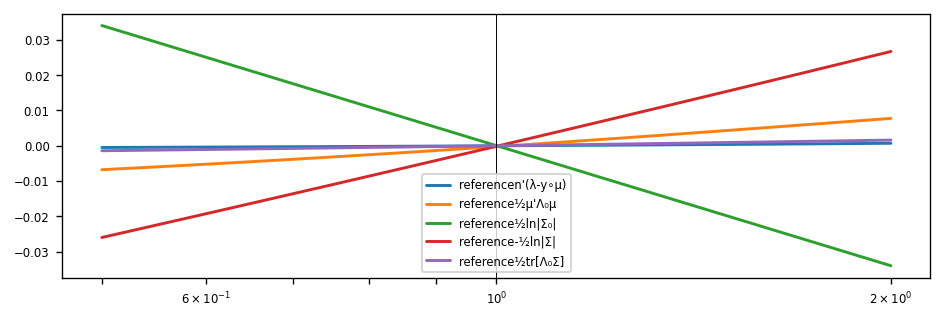

In [24]:
for i,name in enumerate("n'(Œª-y‚àòŒº)  ¬ΩŒº'Œõ‚ÇÄŒº ¬Ωln|Œ£‚ÇÄ| -¬Ωln|Œ£| ¬Ωtr[Œõ‚ÇÄŒ£]".split()):
    plot(Œ≤s,l[:,i]-mean(l[:,i]),label='reference'+name)
    #plot(Œ≤s,l[:,i+5]-mean(l[:,i+5]),label='low-rank'+name)
    #plot(Œ≤s,l[:,i+10]-mean(l[:,i+10]),label='optimized'+name)
legend()
semilogx()
axvline(1,lw=0.5,color='k')
    

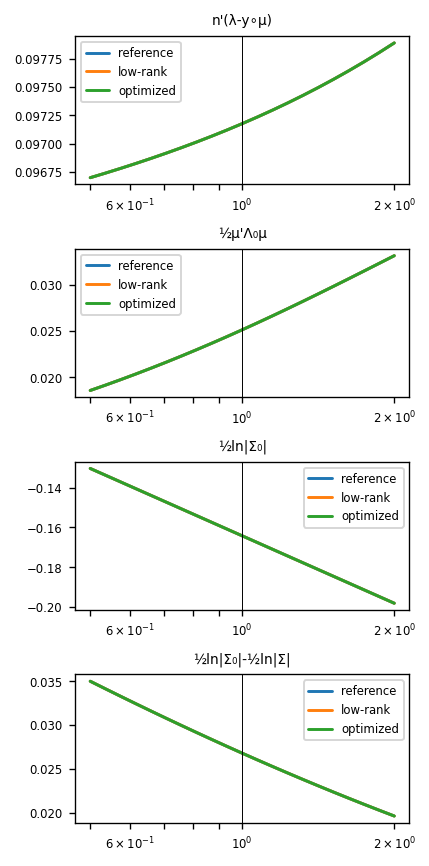

In [25]:
figure(figsize=(3,9))

for i,name in [*enumerate("n'(Œª-y‚àòŒº)  ¬ΩŒº'Œõ‚ÇÄŒº ¬Ωln|Œ£‚ÇÄ| -¬Ωln|Œ£| ¬Ωtr[Œõ‚ÇÄŒ£]".split())][:-2]:
    subplot(6,1,i+1)
    plot(Œ≤s,l[:,i],label='reference')
    plot(Œ≤s,l[:,i+5],label='low-rank')
    plot(Œ≤s,l[:,i+10],label='optimized')
    title(name)
    legend()
    semilogx()
    axvline(1,lw=0.5,color='k')
    
subplot(614)
    
plot(Œ≤s,l[:,2]+l[:,3],label='reference')
plot(Œ≤s,l[:,2+5]+l[:,3+5],label='low-rank')
plot(Œ≤s,l[:,2+10]+l[:,3+10],label='optimized')
title("¬Ωln|Œ£‚ÇÄ|-¬Ωln|Œ£|")
legend()
semilogx()
axvline(1,lw=0.5,color='k')

tight_layout()

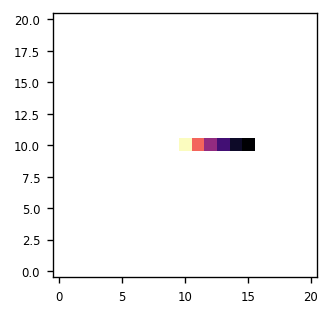

P[10]=8.94 Œ≤[16]=0.66
(initializing)
(getting variance)
(optimizing)
Œº 0.011564751002006466 iteration 0 0
(getting variance)
Iteration 0
Œîv 1.2645099650182567e-05
ŒîŒº 1.160912934139667e-05


In [ ]:
from IPython.display import clear_output

ip = NP//2
iŒ≤ = NŒ≤//2
p  = Ps[ip]
Œ≤  = Œ≤s[iŒ≤]

Œº,v,l = infer(Œº,v,float(Œ≤),float(p))
print('\tŒ≤[%d] ='%iŒ≤,Œ≤,'\tloss = ',l)
Œºref,vref = Œº,v

results = np0.empty((NP,NŒ≤),dtype='object')
def current_best():
    global results
    losses  = array([inf if r is None else np.sum(array(r[2])) for r in results.ravel()])
    bestidx = argmin(losses)
    bestP,bestŒ≤ = unravel_index(bestidx,results.shape)
    return bestP, bestŒ≤, losses[bestidx]  
def search(ip,iŒ≤,suggested_direction=None):
    global results
    # Return if out of bounds; Return memoized if possible; 
    if iŒ≤<0 or ip<0 or iŒ≤>=NŒ≤ or ip>=NP: return
    if results[ip,iŒ≤]: return
    
    print('P[%d]=%0.2f Œ≤[%d]=%0.2f'%(ip,Ps[ip],iŒ≤,Œ≤s[iŒ≤]))
    

    # Get initial conditions via extrapolation when possible
    if iŒ≤+2<NŒ≤ and results[ip,iŒ≤+1] and results[ip,iŒ≤+2]:
        (Œº1,v1),(Œº2,v2) = results[ip,iŒ≤+1][:2], results[ip,iŒ≤+2][:2]
        Œº = 2*Œº1 - Œº2
        v = 2*v1 - v2
    elif iŒ≤>=2 and results[ip,iŒ≤-1] and results[ip,iŒ≤-2]:
        (Œº1,v1),(Œº2,v2) = results[ip,iŒ≤-1][:2], results[ip,iŒ≤-2][:2]
        Œº = 2*Œº1 - Œº2
        v = 2*v1 - v2
    elif iŒ≤+1<NŒ≤ and results[ip,iŒ≤+1]: Œº,v = results[ip,iŒ≤+1][:2]
    elif iŒ≤>=1   and results[ip,iŒ≤-1]: Œº,v = results[ip,iŒ≤-1][:2]
    elif ip+1<NP and results[ip+1,iŒ≤]: Œº,v = results[ip+1,iŒ≤][:2]
    elif ip>=1   and results[ip-1,iŒ≤]: Œº,v = results[ip-1,iŒ≤][:2]
    else: Œº,v = Œºref,vref
    
    Œ≤ = Œ≤s[iŒ≤]
    Œº,v,l = infer(Œº,v,float(Œ≤),float(p))
    results[ip,iŒ≤] = (Œº,v,l)
    print('P[%d]=%0.2f Œ≤[%d]=%0.2f loss=%f'%(ip,Ps[ip],iŒ≤,Œ≤s[iŒ≤],np.sum(array(l))))
    clear_output(wait=True)
    figure()
    imshow(array([sum(array(r[2])) if not r is None else nan for r in results.ravel()]).reshape(NP,NŒ≤))
    show()
    
    # Recursively search nearby
    search_directions = {(0,1),(0,-1),(1,0),(-1,0)}
    # Continue along previous trajectory, if any
    if not suggested_direction is None:
        Œîp,ŒîŒ≤ = suggested_direction
        if current_best()[:2]==(ip,iŒ≤):
            search(ip+Œîp,iŒ≤+ŒîŒ≤,suggested_direction=(Œîp,ŒîŒ≤))
            search_directions -= {(Œîp,ŒîŒ≤)}
    # Try other trajectories
    for Œîp,ŒîŒ≤ in search_directions:
        if current_best()[:2]!=(ip,iŒ≤): break
        search(ip+Œîp,iŒ≤+ŒîŒ≤,suggested_direction=(Œîp,ŒîŒ≤))
    return

ip = NP//2
iŒ≤ = NŒ≤//2
search(ip,iŒ≤)

notify('DONE')

In [ ]:
bestP, bestŒ≤ = current_best()[:2]
Œº,v,l = results[bestP,bestŒ≤]
Œª = exp(Œº + Œº0 + v/2)
subplot(121)
showim(Œª.reshape(L,L),mask=mask)
subplot(122)
showim(1/v.reshape(L,L),mask=mask)
print('Optimized kernel height Œ≤=%f'%Œ≤s[bestŒ≤])
print('Optimized kernel period P=%f'%Ps[bestP])

In [ ]:
imshow(Œº.reshape(L,L))
colorbar()

In [ ]:
p = Ps[bestP]

In [ ]:
Œ≤ = Œ≤s[bestŒ≤]

In [ ]:
'''
Use low-pass filtered velocity angle as heading 
Positive dx is eastwards
Negative dx is westwards
Positive dy is northwards
Negative dy is southwards
Angle is computed as if a complex number
North is +90, West is ¬±180, South is -90, and East is 0.
So, sin(Œ∏) is the vertical direction, with sin(Œ∏)=1 being northwards.
Likewise cos(Œ∏) is the horizontal direction, with cos(Œ∏)=1 being eastwards.
North: positive sin(Œ∏)
South: negative sin(Œ∏)
East : positive cos(Œ∏)
West : negative cos(Œ∏)
œÜ=0    : West
œÜ=1/2œÄ : South
œÜ=œÄ    : East
œÜ=3/2œÄ : North
'''
œÜW,œÜS,œÜE,œÜN = 0, pi/2, pi, 3*pi/2
œÜs  = linspace(0,2*pi,90+1)[:-1]
œÜiW = argmin(abs(œÜs-œÜW))
œÜiS = argmin(abs(œÜs-œÜS))
œÜiE = argmin(abs(œÜs-œÜE))
œÜiN = argmin(abs(œÜs-œÜN))